In [1]:
import numpy as np
import h5py
import matplotlib.pyplot as plt
import scienceplots

import tensorstore as ts

plt.style.use(['science', 'no-latex'])

In [ ]:
PATH_LOAD = "/Users/s/vault/neural_data/janelia/"
subject_id = 17
path = f"{PATH_LOAD}/subject_{subject_id}/"

x = h5py.File(f"{path}/TimeSeries.h5", "r")

In [ ]:
PATH_STORE = "/Users/s/vault/neural_data/janelia/ts_files"

ds_janelia = ts.open({
    'open': True,
    'driver': 'zarr3',
    'kvstore': f'file://{PATH_STORE}/subject_{subject_id}_traces.zarr'
}).result()

ds_traces = ts.open({
    'open': True,
    'driver': 'zarr3',
    'kvstore': 'gs://zapbench-release/volumes/20240930/traces'
}).result()

In [ ]:
x_zap = ds_traces.read().result()
x_jan = ds_janelia.read().result()

Explore some dataset stats

In [ ]:
print(np.mean(x_jan), np.std(x_jan))
print(np.mean(x_zap), np.std(x_zap))

In [ ]:
plt.hist(x_zap.ravel()[::1000], bins=100, density=True, alpha=0.4);
plt.hist(x_jan_n.ravel()[::1000], bins=100, density=True, alpha=0.4);
plt.yscale('log')

In [ ]:
mini, maxi = -0.25, 1.5

In [ ]:
len(np.where(x_zap == mini)[1])

In [ ]:
zap_avg, zap_std = np.mean(x_zap), np.std(x_zap)


In [ ]:
jan_avg, jan_std = np.mean(x_jan), np.std(x_jan)

x_jan_n = ((x_jan - jan_avg)/jan_std) * zap_std + zap_avg

mat files

In [2]:
import scipy.io
import numpy as np

# Load the .mat file
mat_path = "/Users/sebastianvoigtlaender/vault/neural_data/janelia/subject_17/data_full.mat"
mat_data = scipy.io.loadmat(mat_path)

# Show the keys (variable names) in the .mat file
print("Keys in the .mat file:")
for key in mat_data.keys():
    if not key.startswith('__'):  # Skip metadata keys
        print(f"  {key}: {type(mat_data[key])}, shape: {mat_data[key].shape if hasattr(mat_data[key], 'shape') else 'N/A'}")

Keys in the .mat file:
  data: <class 'numpy.ndarray'>, shape: (1, 1)


In [3]:
# The data is stored as a structured array, let's examine its contents
data_struct = mat_data['data'][0, 0]

print("Fields in the data structure:")
field_names = data_struct.dtype.names
for field in field_names:
    field_data = data_struct[field]
    if hasattr(field_data, 'shape'):
        print(f"  {field}: shape {field_data.shape}, dtype {field_data.dtype}")
    else:
        print(f"  {field}: {type(field_data)}")

Fields in the data structure:
  periods: shape (1, 5), dtype uint16
  timelists_names: shape (1, 5), dtype object
  stimuluskey_raw: shape (1, 7400), dtype uint8
  CellXYZ: shape (64813, 3), dtype uint16
  anat_stack: shape (2048, 980, 31), dtype uint16
  fpsec: shape (1, 1), dtype uint8
  Behavior_raw: shape (5, 7400), dtype float64
  numcell_full: shape (1, 1), dtype uint16
  CellXYZ_norm: shape (64813, 3), dtype uint16
  IX_inval_anat: shape (891, 1), dtype uint16
  anat_yx: shape (2048, 980, 3), dtype float64
  anat_yz: shape (2048, 31, 3), dtype float64
  anat_zx: shape (31, 980, 3), dtype float64
  timelists: shape (1, 5), dtype object
  stim_full: shape (1, 5554), dtype uint8
  stimAvr: shape (1, 654), dtype uint8
  Behavior_full: shape (5, 5554), dtype float64
  BehaviorAvr: shape (5, 654), dtype float64
  stimset: shape (1, 5), dtype [('name', 'O'), ('ij', 'O'), ('pattern', 'O'), ('period', 'O'), ('rawstarts', 'O'), ('rawstops', 'O'), ('starts', 'O'), ('stops', 'O'), ('nReps',

In [ ]:
conditions = [0, 1, 2, 3]
condition = 3
ix_by_condition = np.where(data_struct['stim_full'].ravel() == condition)[0]

In [ ]:
interval_ix = np.where(np.diff(ix_by_condition) != 1)[0]
condition_intervals = tuple()
condition_intervals_by_condition = tuple()
for i, j in zip(np.insert(interval_ix, 0, -1), np.insert(interval_ix, len(interval_ix), len(ix_by_condition)-1)):
  condition_intervals_by_condition = condition_intervals + ((int(ix_by_condition[i+1]), int(ix_by_condition[j])),)

In [ ]:
condition_intervals

In [59]:
from zapbench import constants

constants.get_dataset_config(constants.DEFAULT_DATASET)

{'condition_offsets': (0, 649, 2422, 3078, 3735, 5047, 5638, 6623, 7279, 7879),
 'condition_intervals': (((0, 649),),
  ((649, 2422),),
  ((2422, 3078),),
  ((3078, 3735),),
  ((3735, 5047),),
  ((5047, 5638),),
  ((5638, 6623),),
  ((6623, 7279),),
  ((7279, 7879),)),
 'condition_names': ('gain',
  'dots',
  'flash',
  'taxis',
  'turning',
  'position',
  'open loop',
  'rotation',
  'dark'),
 'conditions_train': (0, 1, 2, 4, 5, 6, 7, 8),
 'conditions_holdout': (3,),
 'timeseries_name': '240930_traces',
 'covariate_series_name': '240930_stimuli_features',
 'specs': {'240930_traces': {'kvstore': 'gs://zapbench-release/volumes/20240930/traces/',
   'driver': 'zarr3',
   'transform': {'input_exclusive_max': [[7879], 71721],
    'input_inclusive_min': [0, 0],
    'input_labels': ['t', 'f']}}},
 'covariate_specs': {'240930_stimuli_features': {'kvstore': 'gs://zapbench-release/volumes/20240930/stimuli_features/',
   'driver': 'zarr',
   'rank': 2,
   'metadata': {'shape': [7879, 26]},
   '

In [ ]:
def save_ts(x: np.ndarray, subject_id: str, data_type: str) -> None:
  """Save np array to ts."""
  spec = {
      'driver': 'zarr3',
      'kvstore': {'driver': 'file', 'path': f'{PATH_STORE}/subject_{subject_id}_{data_type}.zarr'},
      'metadata': {
          'shape': [*x.shape],
          'chunk_grid': {'name': 'regular', 'configuration': {'chunk_shape': [512, 512]}},
          'chunk_key_encoding': {'name': 'default'},
          'codecs': [{'name': 'bytes', 'configuration': {'endian': 'little'}}],
          'data_type': 'float32',
          'fill_value': 0.0
      }
  }
  ds = ts.open(spec, create=True).result()
  ds[...] = x

def save_janelia(subject_id: str) -> None:

  h5_path = f"{PATH_LOAD}/subject_{subject_id}/"
  x = h5py.File(f"{h5_path}/TimeSeries.h5", "r")
  x = np.array(x['CellResp']).astype(np.float32)
  save_ts(x, subject_id, "traces")

  mat_path = f"{PATH_LOAD}/subject_{subject_id}/data_full.mat"
  data_struct = scipy.io.loadmat(mat_path)['data'][0, 0]

  coordinates = data_struct['CellXYZ'].astype(np.float32)
  save_ts(coordinates, subject_id, "coordinates")
  behavioral_covariates = data_struct['Behavior_full'].T.astype(np.float32)
  save_ts(behavioral_covariates, subject_id, "behavioral_covariates")


def create_config():
  pass

Save

In [ ]:
PATH_LOAD = "/Users/s/vault/neural_data/janelia/"
PATH_STORE = "/Users/s/vault/neural_data/janelia/ts_files"

# save_janelia(14)

Load

In [ ]:
data_types = ["traces", "coordinates", "behavioral_covariates"]

for data_type in data_types:

  ds_janelia = ts.open({
      'open': True,
      'driver': 'zarr3',
      'kvstore': f'file://{PATH_STORE}/subject_{subject_id}_{data_type}.zarr'
  }).result()

  print(ds_janelia.shape)

SUBJECT 1
[[array(['16 permut: B/W/phototaxis*2'], dtype='<U27')]]
[0 1 2 3]


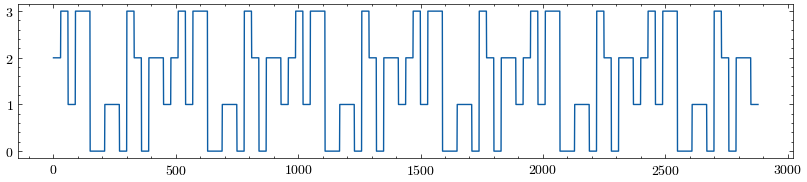

SUBJECT 2
[[array(['16 permut: B/W/phototaxis*2'], dtype='<U27')]]
[0 1 2 3]


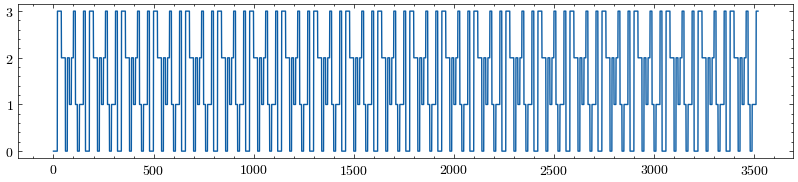

SUBJECT 3
[[array(['16 permut: B/W/phototaxis*2'], dtype='<U27')]]
[0 1 2 3]


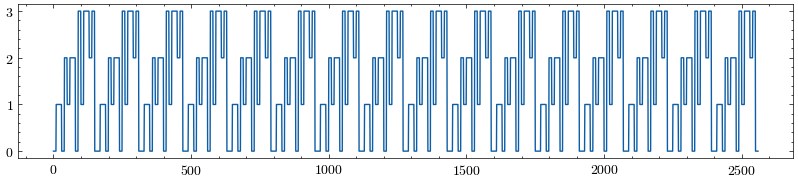

SUBJECT 4
[[array(['16 permut: B/W/phototaxis*2'], dtype='<U27')]]
[0 1 2 3]


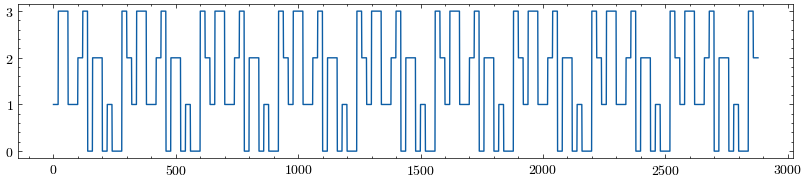

SUBJECT 5
[[array(['16 permut: B/W/phototaxis*2'], dtype='<U27')]]
[0 1 2 3]


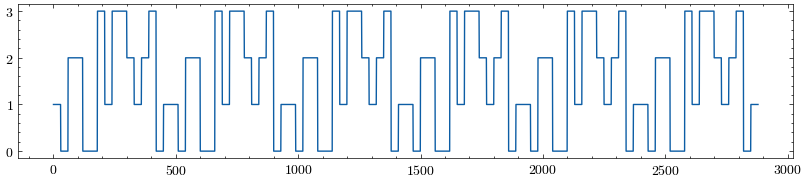

SUBJECT 6
[[array(['phototaxis'], dtype='<U10')]]
[1 2 3]


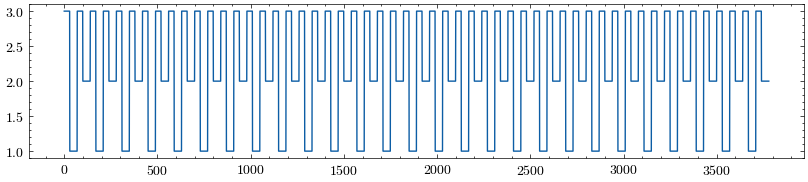

SUBJECT 7
[[array(['phototaxis'], dtype='<U10')]]
[1 2 3]


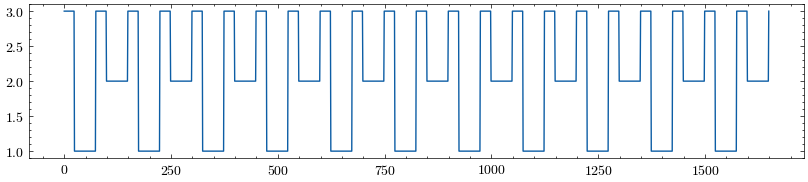

SUBJECT 12
[[array(['PT'], dtype='<U2') array(['OMR'], dtype='<U3')
  array(['DF'], dtype='<U2') array(['Spontaneous'], dtype='<U11')
  array(['Looming'], dtype='<U7')]]
['PT']
[1 2 3]
['OMR']
[ 3  9 10 11 12]
['DF']
[0 3]
['Spontaneous']
[4]
['Looming']
[ 3 14 15]


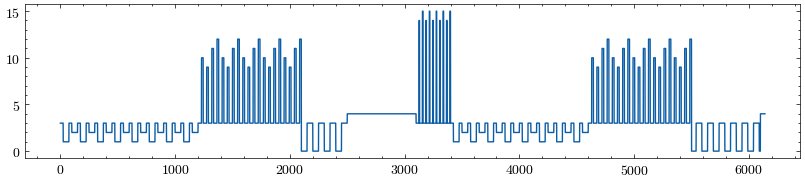

[0 1 2 3 4]


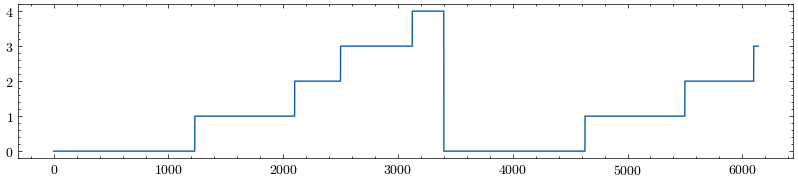

SUBJECT 13
[[array(['PT'], dtype='<U2') array(['OMR'], dtype='<U3')
  array(['DF'], dtype='<U2') array(['Spontaneous'], dtype='<U11')
  array(['Looming'], dtype='<U7')]]
['PT']
[1 2 3]
['OMR']
[ 3  9 10 11 12]
['DF']
[0 3]
['Spontaneous']
[4]
['Looming']
[ 3 14 15]


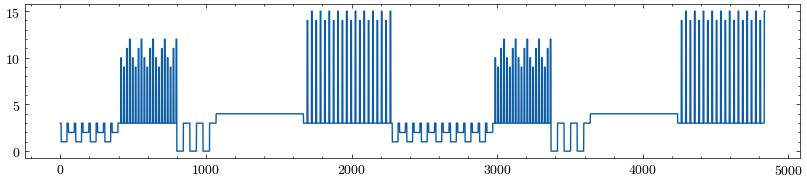

[0 1 2 3 4]


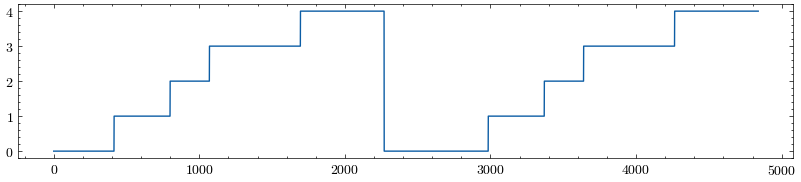

SUBJECT 14
[[array(['PT'], dtype='<U2') array(['OMR'], dtype='<U3')
  array(['DF'], dtype='<U2') array(['Spontaneous'], dtype='<U11')
  array(['Looming'], dtype='<U7')]]
['PT']
[1 2 3]
['OMR']
[ 3  9 10 11 12]
['DF']
[0 3]
['Spontaneous']
[4]
['Looming']
[ 3 14 15]


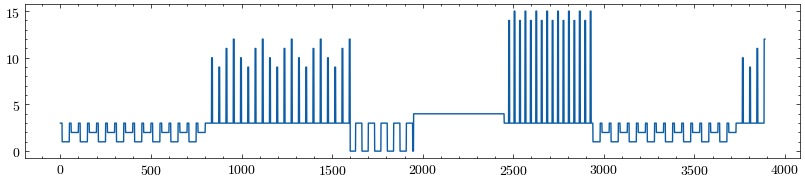

[0 1 2 3 4]


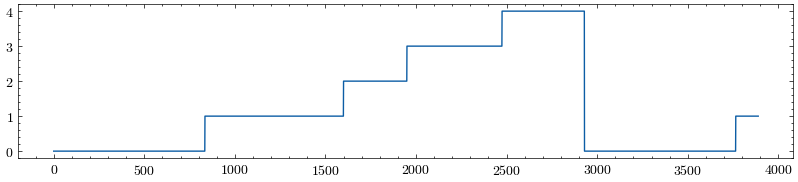

SUBJECT 15
[[array(['PT'], dtype='<U2') array(['OMR'], dtype='<U3')
  array(['DF'], dtype='<U2') array(['Spontaneous'], dtype='<U11')
  array(['Looming'], dtype='<U7')]]
['PT']
[1 2 3]
['OMR']
[ 3  9 10 11 12]
['DF']
[0 3]
['Spontaneous']
[4]
['Looming']
[ 3 14 15]


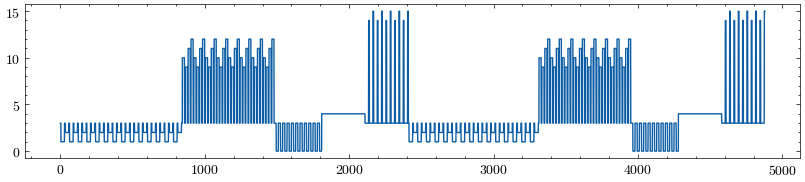

[0 1 2 3 4]


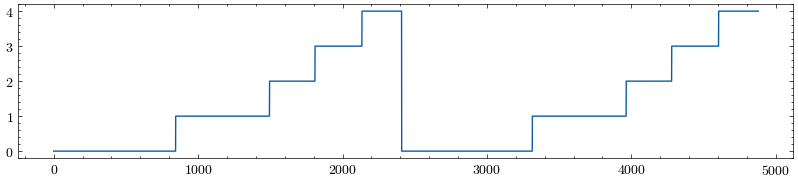

SUBJECT 16
[[array(['PT'], dtype='<U2') array(['OMR'], dtype='<U3')
  array(['Spontaneous'], dtype='<U11')]]
['PT']
[1 2 3]
['OMR']
[ 9 10 11 12]
['Spontaneous']
[4]


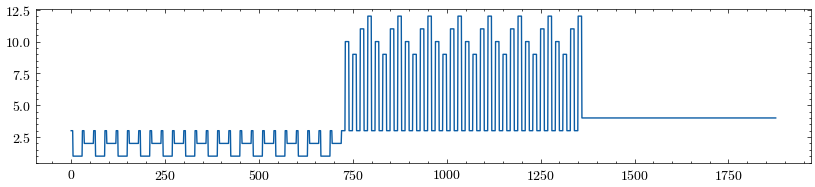

[0 1 2]


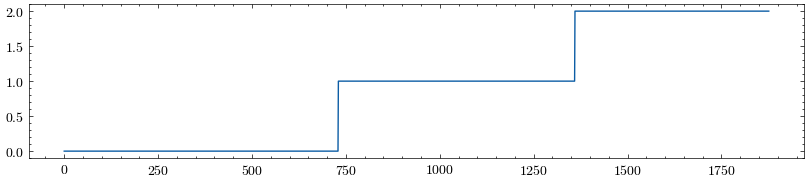

SUBJECT 17
[[array(['PT'], dtype='<U2') array(['OMR'], dtype='<U3')
  array(['DF'], dtype='<U2') array(['Spontaneous'], dtype='<U11')
  array(['Looming'], dtype='<U7')]]
['PT']
[1 2 3]
['OMR']
[ 3  9 10 11 12]
['DF']
[0 3]
['Spontaneous']
[4]
['Looming']
[ 3 14 15]


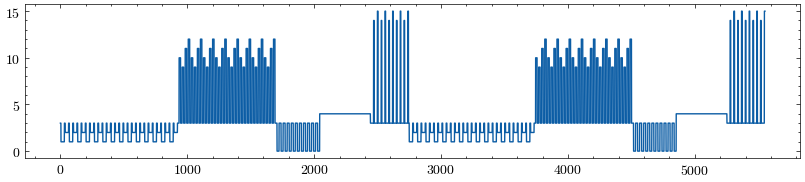

[0 1 2 3 4]


KeyboardInterrupt: 

In [57]:
def fill_gaps_with_max_interval(states, max_interval):
    result = states.copy()
    current = 0
    i = 0

    while i < len(states):
        if states[i] != 0:
            current = states[i]
            i += 1
        else:
            start = i
            while i < len(states) and states[i] == 0:
                i += 1
            if i - start <= max_interval and current != 0:
                for j in range(start, i):
                    result[j] = current

    return result





PATH = "/Users/sebastianvoigtlaender/vault/neural_data/janelia"
subject_id_list = [1, 2, 3, 4, 5, 6, 7, 12, 13, 14, 15, 16, 17]
for subject_id in subject_id_list:
  print('SUBJECT', subject_id)
  mat_path = f"{PATH}/subject_{subject_id:02d}/data_full.mat"
  mat_data = scipy.io.loadmat(mat_path)
  data_struct = mat_data['data'][0, 0]

  if 'stimset' in data_struct.dtype.fields:
    print(data_struct['stimset']['name'])
    stim_full = data_struct['stim_full'].ravel()

    stim_full_harmonized = np.zeros_like(stim_full)

    n_conditions = data_struct['stimset'].shape[-1]
    for i in range(n_conditions):
      print(data_struct['stimset'][0, i]['name'])
      pattern = np.unique(data_struct['stimset'][0, i]['pattern'])
      print(pattern)
      indices = np.where(np.isin(data_struct['stim_full'].ravel(), pattern[pattern != 3]))[0]
      stim_full_harmonized[indices] = i


    plt.figure(figsize=(10, 2))
    plt.plot(stim_full)
    plt.show()
    result = fill_gaps_with_max_interval(stim_full_harmonized, 100)
    print(np.unique(result))
    plt.figure(figsize=(10, 2))
    plt.plot(result)
    plt.show()

  else:
    print(data_struct['timelists_names'])
    stim_full = data_struct['stim_full'].ravel()
    print(np.unique(stim_full))
    plt.figure(figsize=(10, 2))
    plt.plot(stim_full)
    plt.show()

In [1]:
ds_stimuli_features = ts.open({
    'open': True,
    'driver': 'zarr',
    'kvstore': 'gs://zapbench-release/volumes/20240930/stimuli_features'
}).result()

NameError: name 'ts' is not defined

In [ ]:
stimuli_features = ds_stimuli_features.read().result()

In [ ]:
plt.plot(stimuli_features[..., 0])

In [ ]:
for i in range(n_conditions):
  print(data_struct['stimset'][0, i]['name'])
  pattern = np.unique(data_struct['stimset'][0, i]['pattern'])
  print(pattern)


['PT']
[1 2 3]
['OMR']
[ 3  9 10 11 12]
['DF']
[0 3]
['Spontaneous']
[4]
['Looming']
[ 3 14 15]


In [46]:
subject_id = 1
print('SUBJECT', subject_id)
mat_path = f"{PATH}/subject_{subject_id:02d}/data_full.mat"
mat_data = scipy.io.loadmat(mat_path)
data_struct = mat_data['data'][0, 0]
stim_full = data_struct['stim_full'].ravel()
print(np.unique(stim_full))

SUBJECT 1
[0 1 2 3]


In [49]:
data_struct.dtype.fields

mappingproxy({'periods': (dtype('O'), 0),
              'timelists_names': (dtype('O'), 8),
              'stimuluskey_raw': (dtype('O'), 16),
              'CellXYZ': (dtype('O'), 24),
              'anat_stack': (dtype('O'), 32),
              'fpsec': (dtype('O'), 40),
              'Behavior_raw': (dtype('O'), 48),
              'numcell_full': (dtype('O'), 56),
              'CellXYZ_norm': (dtype('O'), 64),
              'IX_inval_anat': (dtype('O'), 72),
              'anat_yx': (dtype('O'), 80),
              'anat_yz': (dtype('O'), 88),
              'anat_zx': (dtype('O'), 96),
              'timelists': (dtype('O'), 104),
              'stim_full': (dtype('O'), 112),
              'stimAvr': (dtype('O'), 120),
              'Behavior_full': (dtype('O'), 128),
              'BehaviorAvr': (dtype('O'), 136),
              'Behavior_full_motorseed': (dtype('O'), 144),
              'BehaviorAvr_motorseed': (dtype('O'), 152),
              'Eye_full_motorseed': (dtype('O'), 160)

[[array(['16 permut: B/W/phototaxis*2'], dtype='<U27')]]


In [ ]:
def generate_dataset_config(dataset_name: str) -> None:
  pass

DATASET_CONFIGS = {
    '[NAME]': {
        'condition_intervals': ( [SELF: UPDATE TO CORRECT INTERVALS]
            ((0, 649),),
            ((649, 2422),),
            ((2422, 3078),),
            ((3078, 3735),),
            ((3735, 5047),),
            ((5047, 5638),),
            ((5638, 6623),),
            ((6623, 7279),),
            ((7279, 7879),),
        ),
        'condition_names': (
            'taxis'
            'optomotor_response'
            'looming'
            'dark-flash response'
        ),
        'conditions_train': (0, 1, 3),
        'conditions_holdout': (2,),
        'timeseries_name': 'subject_{subject_id}',
        'covariate_series_name': '240930_stimuli_features', [BETTER NAME]
        'specs': {
            'subject_{subject_id}': {
                'kvstore': path_to_traces,
                'driver': 'zarr3',
                'transform': {
                    'input_exclusive_max': [[7879], 71721], [SHAPE HERE]
                    'input_inclusive_min': [0, 0],
                    'input_labels': ['t', 'f'],
                },
            },
        },
        'covariate_specs': {
            '240930_stimuli_features': { [SAME]
                'kvstore': (
                    'gs://zapbench-release/volumes/20240930/stimuli_features/' [PATH]
                ),
                'driver': 'zarr', [UPDATE DRIVER SPECS]
                'rank': 2,
                'metadata': {'shape': [7879, 26]},
                'transform': {
                    'input_inclusive_min': [0, 0],
                    'input_exclusive_max': [[7879], [26]],
                    'input_labels': ['t', 'f'],
                },
        },
        'min_max_values': {
            '240930_traces': (-0.25, 1.5), [SELF: CHECK THIS BEFORE SAVING, AND CLIP OFF IF NEEDED IN SAVE, OR MAYBE MAKE A PREPROCESSING FN]
        },
        'position_embedding_specs': { [SAME SET OF CHANGES HERE]
            '240930_traces': {
                'kvstore': (
                    'gs://zapbench-release/volumes/20240930/position_embedding/'
                ),
                'driver': 'zarr',
                'rank': 2,
                'metadata': {'shape': [71721, 192]},
                'transform': {
                    'input_inclusive_min': [0, 0],
                    'input_exclusive_max': [[71721], [192]],
                    'input_labels': ['f', 'a'],
                },
            }
        },
    },
}